### Examine the Data

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


# Read the dataset
df = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
df.index.freq = 'MS'

df.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [141]:
df.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

In [142]:
len(df)

15001

### Plot the source data

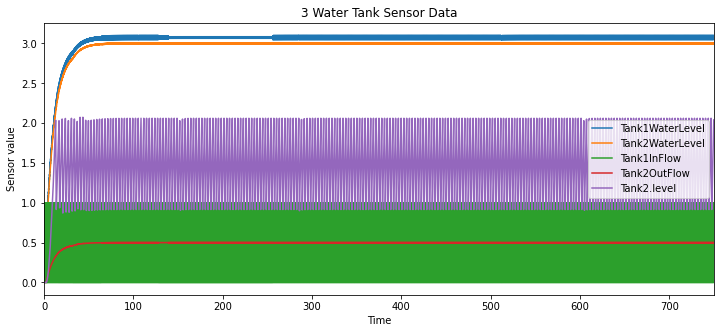

In [143]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Tank2WaterLevel'].plot(legend=True)
df['Tank1InFlow'].plot(legend=True)
df['Tank2OutFlow'].plot(legend=True)
# df['wt3_valve'].plot(legend=True)
# df['Tank3OutFlow'].plot(legend=True)
df['Tank2.level'].plot(legend=True)
plt.show()

In [144]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [145]:
adf_test(df['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.325979e+01
p-value                 8.443583e-25
#lags                   4.200000e+01
#observations           1.495800e+04
critical value (1%)    -3.430787e+00
critical value (5%)    -2.861733e+00
critical value (10%)   -2.566873e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [146]:
# All the correlated features are stationary.
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [147]:
len(df)

15001

In [148]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(12001, 3000)

### VAR Model Order Selection

In [149]:
p = [1,2,3,4,5,6,7] # try with list of 7 p values
p = list(range(1,20))
aic, bic = [], []
for i in p:
    model = VAR(train)
    results = model.fit(i)
    aic.append(results.aic)
    bic.append(results.bic)
    print(f'VAR Order {i}')
    print('AIC: {}'.format(results.aic))
    print('BIC: {}'.format(results.bic))
    print()

min_aic = min(aic)
min_aic_index = aic.index(min_aic) + 1
min_bic = min(bic)
min_bic_index = bic.index(min_bic) + 1
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


VAR Order 1
AIC: -60.59531714793363
BIC: -60.560818058932696

VAR Order 2
AIC: -65.63765332586213
BIC: -65.57296287231132

VAR Order 3
AIC: -68.83629887405118
BIC: -68.7414127040041

VAR Order 4
AIC: -71.73807898824147
BIC: -71.61299274874862

VAR Order 5
AIC: -73.21783149529934
BIC: -73.06254083240779

VAR Order 6
AIC: -74.31535001802344
BIC: -74.12985057677646

VAR Order 7
AIC: -75.34746254434351
BIC: -75.13174996878031

VAR Order 8
AIC: -75.71192326506527
BIC: -75.46599319822064

VAR Order 9
AIC: -76.24927726338815
BIC: -75.97312534729221

VAR Order 10
AIC: -77.96340527798844
BIC: -77.65702715366623

VAR Order 11
AIC: -78.44504337582897
BIC: -78.10843468330022

VAR Order 12
AIC: -79.365875176055
BIC: -78.99903155433375

VAR Order 13
AIC: -79.8242658031386
BIC: -79.42718289023294

VAR Order 14
AIC: -80.63408532999813
BIC: -80.20675876290983

VAR Order 15
AIC: -81.08399497173683
BIC: -80.62642038646105

VAR Order 16
AIC: -81.88838131535853
BIC: -81.40055434688351

VAR Order 17
AIC: -8

In [150]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

In [151]:
from IPython.display import Markdown as md
md("Fit the VAR( {{}} ) model".format(min_aic_index))

Fit the VAR( {} ) model

### Fit the VAR {{min_aic_index}}  model

In [152]:
min_aic_index

19

In [153]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Apr, 2023
Time:                     12:11:54
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -83.5088
Nobs:                     11982.0    HQIC:                  -83.8933
Log likelihood:           385694.    FPE:                3.02893e-37
AIC:                     -84.0874    Det(Omega_mle):     2.80207e-37
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.018286         0.002191            8.345           0.000
L1.Tank1WaterLevel          0.331329         0.010402           31.852           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [154]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

19

In [155]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [156]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 3.09256035e+00,  3.00416350e+00, -1.13065223e-03,
         5.00302493e-01, -4.74730298e-02, -5.83939576e-04,
         1.43187225e+00],
       [ 3.06262596e+00,  3.00404855e+00, -8.31531803e-04,
         5.00995644e-01, -7.28905293e-02, -1.30458499e-01,
         1.46604522e+00],
       [ 3.04798313e+00,  2.99868363e+00,  8.49938832e-03,
         5.00280687e-01, -9.61344031e-02, -1.90119594e-01,
         1.49807663e+00],
       [ 3.07880621e+00,  2.99456106e+00,  1.00066702e+00,
         4.98970156e-01, -1.01742594e-01, -2.46348184e-01,
         1.53722392e+00],
       [ 3.09521881e+00,  2.99834313e+00,  9.97111540e-01,
         4.99272058e-01, -1.05787464e-01, -2.44756983e-01,
         1.57348753e+00],
       [ 3.08106845e+00,  3.00565221e+00, -3.54276497e-04,
         5.00792021e-01, -1.00647510e-01, -2.47002652e-01,
         1.61178184e+00],
       [ 3.06248239e+00,  3.00403149e+00, -1.58546697e-03,
         5.00992828e-01, -9.11864595e-02, -2.15810676e-01,
         1.6476907

In [157]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
Time,,,,,,,
600.05,3.092560,3.004144,0,0.500300,0,0.0,1.431050
600.10,3.062618,3.004037,0,0.500995,0,0.0,1.461065
600.15,3.047931,2.998697,0,0.500285,0,0.0,1.481102
600.20,3.078778,2.994546,1,0.498971,0,0.0,1.511121
600.25,3.095067,2.998294,1,0.499269,0,0.0,1.531085
...,...,...,...,...,...,...,...
749.80,3.092561,3.004145,0,0.500300,0,0.0,1.941046
749.85,3.071222,3.005454,0,0.501029,0,0.0,1.961054
749.90,3.047931,2.998697,0,0.500285,0,0.0,1.991114


In [158]:
# idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
# df_forecast = pd.DataFrame(z, index=idx, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast = pd.DataFrame(z, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,3.092560,3.004163,-0.001131,0.500302,-0.047473,-0.000584,1.431872
1,3.062626,3.004049,-0.000832,0.500996,-0.072891,-0.130458,1.466045
2,3.047983,2.998684,0.008499,0.500281,-0.096134,-0.190120,1.498077
3,3.078806,2.994561,1.000667,0.498970,-0.101743,-0.246348,1.537224
4,3.095219,2.998343,0.997112,0.499272,-0.105787,-0.244757,1.573488


### Plot the results

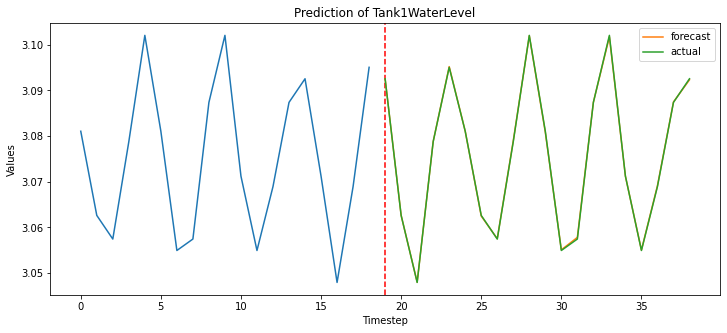

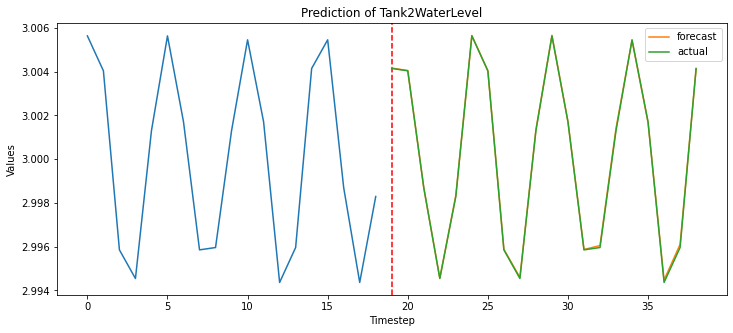

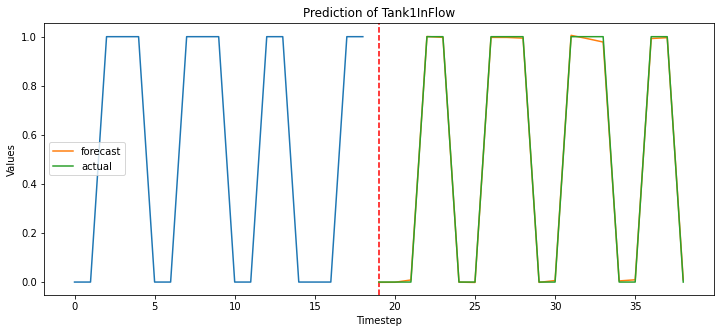

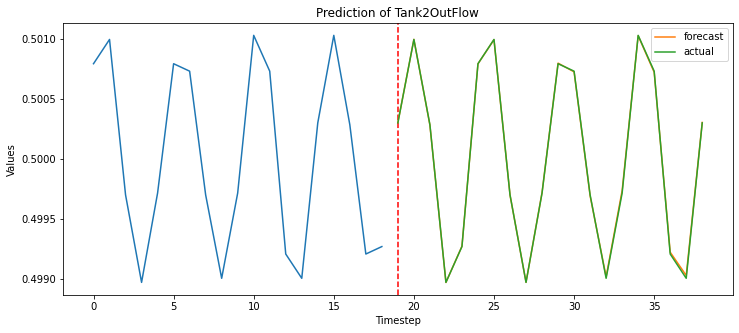

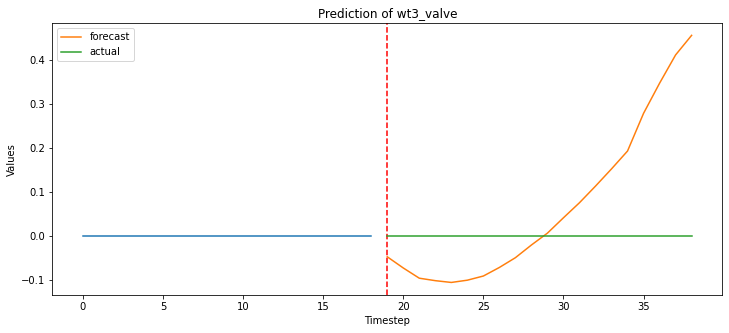

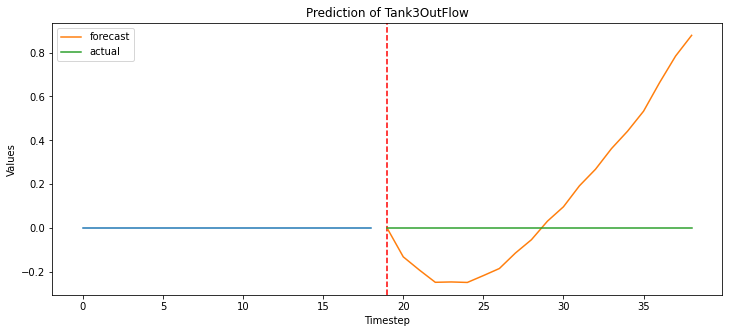

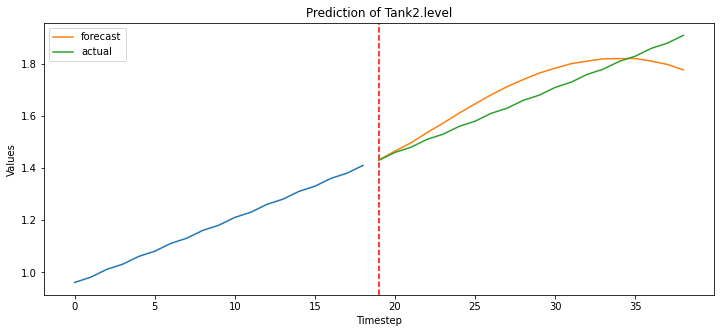

In [167]:
attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(lag_order)))
    actual = train.iloc[-lag_order:,:]
    
    index = pd.Index(list(range(lag_order, lag_order + steps)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:lag_order+1,:].set_index(index)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

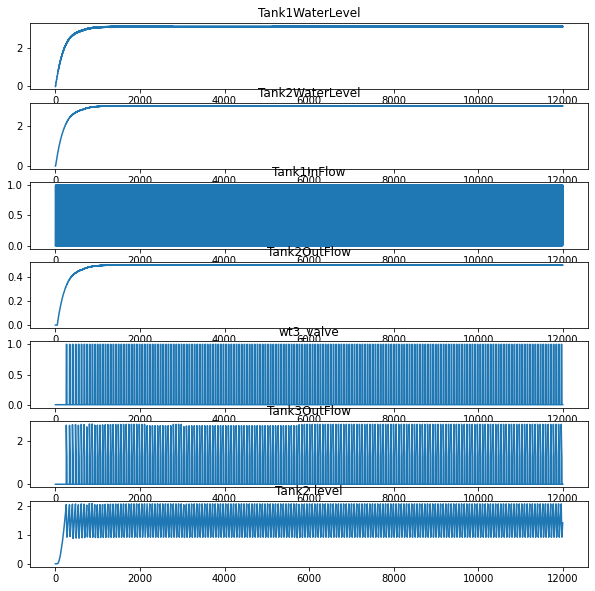

In [128]:
results.plot();

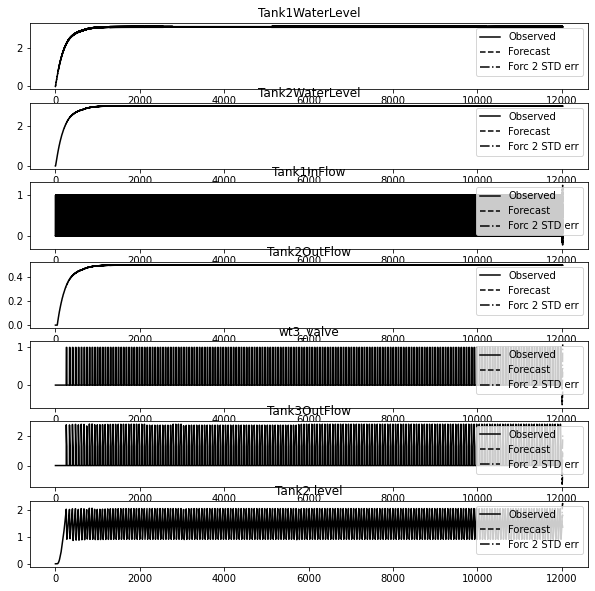

In [134]:
results.plot_forecast(20);

In [130]:
len(df_forecast)

20

In [133]:
len(df['Tank1WaterLevel'].iloc[:steps])

20

### Model Evaluation

In [139]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(df[feat].iloc[:steps], df_forecast[feat]))

print(RMSE)

[2.9536769630560697, 2.9092906435340624, 0.735708183695846, 0.5000138673714787, 0.1897547607072723, 0.3798970015733955, 1.7010074271360265]
